[View in Colaboratory](https://colab.research.google.com/github/abhinavrk/GoogleColabMusings/blob/master/char_rnn_classification_assignment4.ipynb)

In [0]:
loaded = False

if not loaded:
  # http://pytorch.org/
  from os import path
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

  accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

  !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

  import torch
  loaded = True

In [16]:
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip

--2018-07-18 20:08:49--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 143.204.101.39, 143.204.101.114, 143.204.101.64, ...
Connecting to download.pytorch.org (download.pytorch.org)|143.204.101.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2018-07-18 20:08:49 (53.7 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
%matplotlib inline

In [18]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/German.txt']
Slusarski


In [19]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn

class RNN_linear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_linear, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
import torch.nn as nn

class RNN_gru(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_gru, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRU(input_size + hidden_size, hidden_size)
        self.i2o = nn.GRU(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined.unsqueeze(0))
        output = self.i2o(combined.unsqueeze(0))
        output = self.softmax(output[0].squeeze(0))
        return output, hidden[0].squeeze(0)

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
import torch.nn as nn

class RNN_lstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_lstm, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTM(input_size + hidden_size, hidden_size)
        self.i2o = nn.LSTM(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined.unsqueeze(0))
        output = self.i2o(combined.unsqueeze(0))
        output = self.softmax(output[0].squeeze(0))
        return output, hidden[0].squeeze(0)

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(rnn, category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [0]:
criterion = nn.NLLLoss()

In [0]:
def do_train(rnn, all_losses):

  import time
  import math

  n_iters = 100000
  print_every = 5000
  plot_every = 1000



  # Keep track of losses for plotting
  current_loss = 0

  def timeSince(since):
      now = time.time()
      s = now - since
      m = math.floor(s / 60)
      s -= m * 60
      return '%dm %ds' % (m, s)

  start = time.time()

  for iter in range(1, n_iters + 1):
      category, line, category_tensor, line_tensor = randomTrainingExample()
      output, loss = train(rnn, category_tensor, line_tensor)
      current_loss += loss

      # Print iter number, loss, name and guess
      if iter % print_every == 0:
          guess, guess_i = categoryFromOutput(output)
          correct = '✓' if guess == category else '✗ (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

      # Add current loss avg to list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

In [0]:
n_hidden = 128
rnn_linear = RNN_linear(n_letters, n_hidden, n_categories)
rnn_gru = RNN_gru(n_letters, n_hidden, n_categories)
rnn_lstm = RNN_lstm(n_letters, n_hidden, n_categories)
# input_linear = letterToTensor('A')
# hidden_linear =torch.zeros(1, n_hidden)

# output_linear, next_hidden_linear = rnn_linear(input_linear, hidden_linear)

5000 5% (0m 7s) 2.0456 Imada / Japanese ✓
10000 10% (0m 15s) 2.7171 Sinagra / Japanese ✗ (Italian)
15000 15% (0m 22s) 4.0266 Jones / Dutch ✗ (Scottish)
20000 20% (0m 30s) 3.6010 Kurmochi / Italian ✗ (Japanese)
25000 25% (0m 37s) 0.2426 Vedikhov / Russian ✓
30000 30% (0m 45s) 1.6867 Skeril / Czech ✓
35000 35% (0m 53s) 2.9388 Cham / Vietnamese ✗ (Arabic)
40000 40% (1m 1s) 2.3938 Lowe / Japanese ✗ (German)
45000 45% (1m 8s) 1.9471 Obando / Italian ✗ (Spanish)
50000 50% (1m 16s) 1.0844 Gu / Vietnamese ✗ (Korean)
55000 55% (1m 23s) 2.9769 Zuraw / Vietnamese ✗ (Polish)
60000 60% (1m 31s) 0.1372 Biancardi / Italian ✓
65000 65% (1m 38s) 0.6719 Rzehak / Czech ✓
70000 70% (1m 46s) 2.8042 Hawes / Arabic ✗ (English)
75000 75% (1m 53s) 0.0862 Dickson / Scottish ✓
80000 80% (2m 1s) 0.0549 Bahovtsev / Russian ✓
85000 85% (2m 8s) 0.1126 Davletov / Russian ✓
90000 90% (2m 16s) 0.5189 Kusatsu / Japanese ✓
95000 95% (2m 23s) 0.4356 Echevarria / Spanish ✓
100000 100% (2m 31s) 0.3652 Zientek / Polish ✓
500

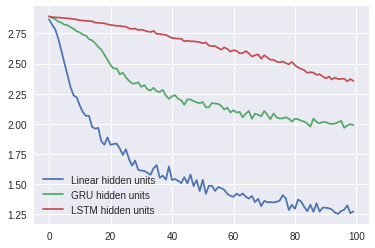

In [106]:
import matplotlib.pyplot as plt

all_losses_linear = []
all_losses_gru = []
all_losses_lstm = []


do_train(rnn_linear, all_losses_linear)
do_train(rnn_gru, all_losses_gru)
do_train(rnn_lstm, all_losses_lstm)


plt.figure()
plt.plot(all_losses_linear, label='Linear hidden units')
plt.plot(all_losses_gru, label='GRU hidden units')
plt.plot(all_losses_lstm, label='LSTM hidden units')
plt.legend()